In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Conditional check for unzipping
unzip = True

# Unzip the 'public_data.zip' file if the 'unzip' flag is True
if unzip:
    !unzip "/content/drive/MyDrive/Homework 1/public_data.zip"

Archive:  /content/drive/MyDrive/Homework 1/public_data.zip
  inflating: public_data.npz         


### Imports

In [3]:
!pip install -U tensorflow==2.14.0

In [4]:
seed = 42

import os
import numpy as np
np.random.seed(seed)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.layers import Concatenate

# mixed precision throws errors when training ConvNeXT
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

### Load Data

In [5]:
data = np.load(os.path.join(os.path.abspath(""), 'public_data.npz'), allow_pickle=True)
# data = np.load('../input/train-data/public_data/public_data/public_data.npz', allow_pickle=True)
print(data['data'].shape)
print(data['data'][0])
print('###########')
print(data['labels'].shape)
print(data['labels'][0:10])

(5200, 96, 96, 3)
[[[ 20.  38.   0.]
  [ 44.  62.  22.]
  [151. 173. 127.]
  ...
  [177. 220. 149.]
  [180. 224. 149.]
  [181. 225. 148.]]

 [[ 18.  35.   1.]
  [ 12.  29.   0.]
  [ 85. 106.  65.]
  ...
  [177. 220. 149.]
  [179. 223. 148.]
  [179. 223. 146.]]

 [[ 12.  23.   6.]
  [  9.  22.   2.]
  [  1.  17.   0.]
  ...
  [171. 213. 147.]
  [170. 213. 142.]
  [170. 213. 141.]]

 ...

 [[  3.  13.   2.]
  [  6.  16.   5.]
  [ 11.  18.  10.]
  ...
  [101. 139.  82.]
  [ 83. 115.  66.]
  [ 81. 113.  64.]]

 [[  6.  17.   0.]
  [  8.  19.   2.]
  [ 15.  23.   8.]
  ...
  [ 87. 125.  68.]
  [ 98. 130.  80.]
  [ 90. 122.  73.]]

 [[  6.  18.   0.]
  [  8.  20.   0.]
  [ 19.  27.  12.]
  ...
  [ 79. 117.  60.]
  [106. 138.  88.]
  [101. 133.  84.]]]
###########
(5200,)
['healthy' 'healthy' 'healthy' 'unhealthy' 'unhealthy' 'healthy'
 'unhealthy' 'healthy' 'healthy' 'healthy']


### Remove obvious outliers


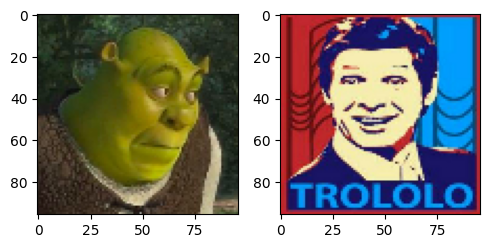

(5004, 96, 96, 3)
(5004,)


In [6]:
# remove shrek and trololol
#with open('../input/train-data/shrek.npy', 'rb') as f:
with open('shrek.npy', 'rb') as f:
    shrek = np.load(f)

# with open('../input/train-data/trololol.npy', 'rb') as f:
with open('trololol.npy', 'rb') as f:
    trololol = np.load(f)

fig, axes = plt.subplots(1, 2, figsize=(5, 5))

axes[0].imshow(shrek)
axes[1].imshow(trololol)
plt.tight_layout()
plt.show()

data_normalized = (data['data']/ 255).astype('float32')

mask = [not(np.array_equal(elem, shrek) or np.array_equal(elem, trololol)) for elem in data_normalized]
X= data['data'][mask]
labels = data['labels'][mask]
print(X.shape)
print(labels.shape)

### Label Distribution

In [7]:
# Calculate the unique target labels and their counts
unique, count = np.unique(labels, return_counts=True)
print('Target labels:', unique)
for u in range(unique.size):
    print(f'Class {unique[u]} has {count[u]} samples')

Target labels: ['healthy' 'unhealthy']
Class healthy has 3101 samples
Class unhealthy has 1903 samples


### Split Dataset

In [8]:
# split into training and validation
# splitting a test dataset is not necessary since we test on the codalab dataset
X_train, X_val, y_train, y_val = train_test_split(
    X,
    labels,
    test_size = 0.15,
    random_state = seed,
    stratify = labels
)

# Print the shapes of the resulting sets
print('Training set shape:\t',X_train.shape, y_train.shape)
print('Validation set shape:\t',X_val.shape, y_val.shape)

Training set shape:	 (4253, 96, 96, 3) (4253,)
Validation set shape:	 (751, 96, 96, 3) (751,)


### Normalization

In [9]:
# Normalize data to the range [0, 1]
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')

# Convert labels to 0/1 -> 0 = healthy, 1 = unhealthy (as specified in codalab)
y_train = (y_train=='unhealthy').astype(int)
y_val = (y_val=='unhealthy').astype(int)

# one-hot-encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))

print(X_train[0])
print(y_train)

[[[0.23921569 0.41568628 0.16078432]
  [0.23529412 0.4117647  0.15686275]
  [0.24705882 0.41960785 0.17254902]
  ...
  [0.24705882 0.24705882 0.20784314]
  [0.24313726 0.24313726 0.20392157]
  [0.2509804  0.2509804  0.21176471]]

 [[0.2627451  0.4392157  0.18431373]
  [0.25882354 0.43529412 0.18039216]
  [0.26666668 0.4392157  0.19215687]
  ...
  [0.23921569 0.23921569 0.2       ]
  [0.24705882 0.24705882 0.20784314]
  [0.25882354 0.25882354 0.21960784]]

 [[0.29411766 0.46666667 0.21960784]
  [0.2901961  0.4627451  0.21568628]
  [0.2901961  0.4627451  0.21568628]
  ...
  [0.22352941 0.22352941 0.1764706 ]
  [0.2509804  0.2509804  0.20392157]
  [0.2627451  0.2627451  0.21568628]]

 ...

 [[0.3647059  0.49411765 0.28627452]
  [0.34509805 0.4745098  0.26666668]
  [0.34901962 0.48235294 0.28235295]
  ...
  [0.04313726 0.07450981 0.02352941]
  [0.04705882 0.07843138 0.02745098]
  [0.05098039 0.08235294 0.03137255]]

 [[0.32156864 0.4509804  0.24313726]
  [0.3254902  0.45490196 0.24705882]


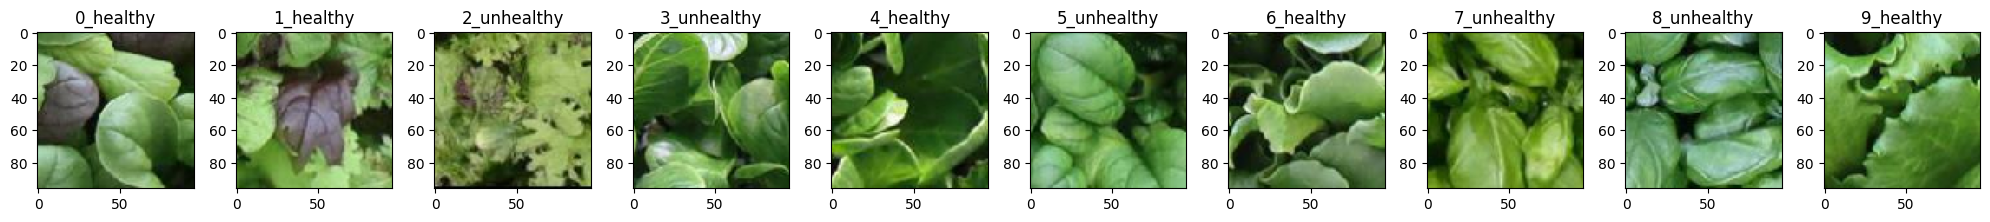

In [10]:
# Display a sample of images from the training dataset
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(X_train[i])
    ax.set_title(str(i) + '_' + ('unhealthy' if y_train[i][1] else 'healthy'))  # Show the corresponding digit label

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [11]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1:]  # Output shape for the model
batch_size = 64                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 64
Input Shape: (96, 96, 3)
Output Shape: (2,)


### Build Model

83683744/83683744 [==============================] - 5s 0us/step


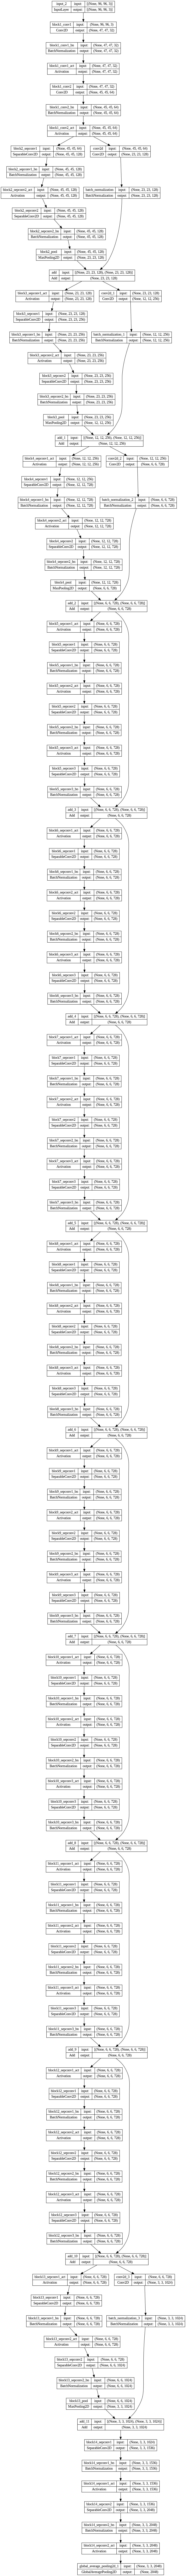

In [12]:
# define base models used for transfer learning
model_convnext = tfk.applications.ConvNeXtBase(
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    include_top=False)
tfk.utils.plot_model(model_convnext, show_shapes=True)

model_xception = tfk.applications.Xception(
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    include_top=False)
tfk.utils.plot_model(model_xception, show_shapes=True)

In [13]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
model_convnext.trainable = False
model_xception.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=input_shape)

preprocessing = tf.keras.Sequential([
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.5),
    tfkl.RandomFlip(mode='horizontal_and_vertical')
], name='preprocessing')

preprocessing = preprocessing(inputs)

# Preprocess input data for the first base model
input_data_convnext = convnext_preprocess_input(preprocessing)
# Preprocess input data for the second base model
input_data_xception = xception_preprocess_input(preprocessing)

# Connect models to the input
x_convnext = model_convnext(input_data_convnext)
x_xception = model_xception(input_data_xception)

# Concatenate the outputs of the two base models
concatenated_output = Concatenate()([x_convnext, x_xception])

# add hidden layers
x = tfkl.Dense(units=256, activation='relu')(concatenated_output)
x = tfkl.Dense(units=128, activation='relu')(x)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics=[
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
])

# Display model summary
tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_3[0][0]']             
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)            0         ['preprocessing[0][0]']       
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)            0         ['tf.math.truediv[0][0]'] 

In [14]:
# class weight
# the dataset is slightly imbalanced
# this puts more weight on the unhealthy class
weight_for_0 = (1 / count[0]) * (X.shape[0] / 2.0)
weight_for_1 = (1 / count[1]) * (X.shape[0] / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.8068365043534343, 1: 1.3147661586967945}


In [15]:
# Train the model
tl_history = tl_model.fit(
    x = X_train*255, #preprocessing is applied inside the model
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val*255, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=40, restore_best_weights=True)],
    class_weight=class_weight
).history

Epoch 1/200
67/67 [==============================] - 89s 813ms/step - loss: 0.5269 - binary_accuracy: 0.7327 - precision: 0.7327 - recall: 0.7327 - val_loss: 0.4402 - val_binary_accuracy: 0.7883 - val_precision: 0.7883 - val_recall: 0.7883
Epoch 2/200
67/67 [==============================] - 22s 330ms/step - loss: 0.4238 - binary_accuracy: 0.8027 - precision: 0.8027 - recall: 0.8027 - val_loss: 0.3473 - val_binary_accuracy: 0.8482 - val_precision: 0.8482 - val_recall: 0.8482
Epoch 3/200
67/67 [==============================] - 22s 331ms/step - loss: 0.4016 - binary_accuracy: 0.8133 - precision: 0.8133 - recall: 0.8133 - val_loss: 0.3138 - val_binary_accuracy: 0.8615 - val_precision: 0.8615 - val_recall: 0.8615
Epoch 4/200
67/67 [==============================] - 24s 359ms/step - loss: 0.3693 - binary_accuracy: 0.8389 - precision: 0.8389 - recall: 0.8389 - val_loss: 0.4456 - val_binary_accuracy: 0.8109 - val_precision: 0.8109 - val_recall: 0.8109
Epoch 5/200
67/67 [=====================

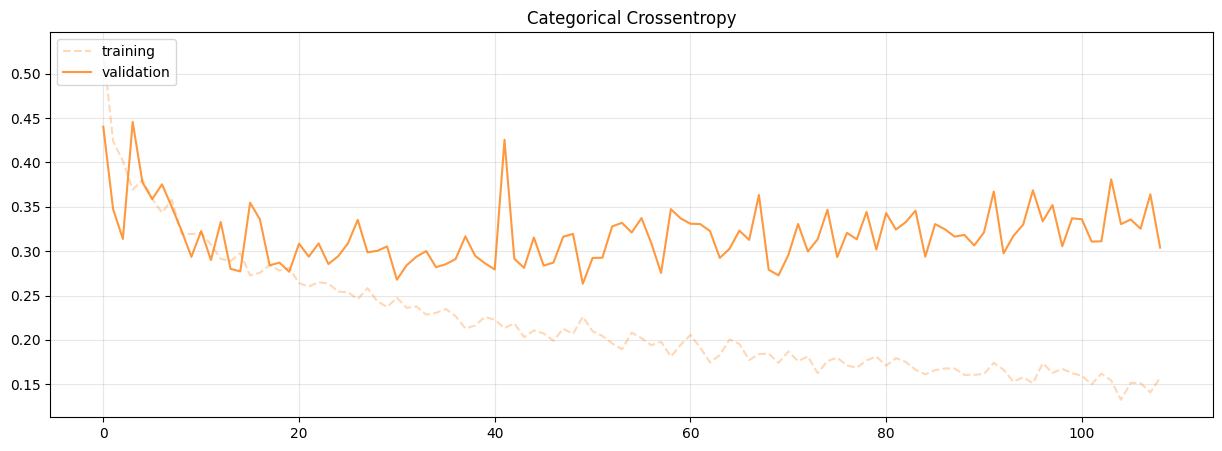

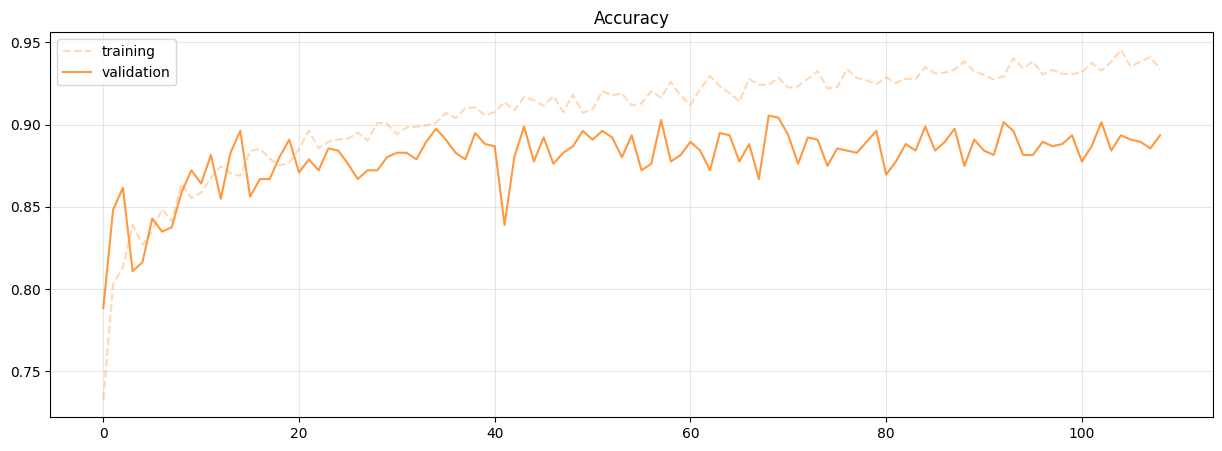

In [16]:
# Plot the re-trained training history
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_loss'], label='validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['binary_accuracy'], alpha=.3, label='training', color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_binary_accuracy'], label='validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [17]:
# Save the best model
tl_model.save('TransferLearningModel')

In [19]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_3[0][0]']             
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)            0         ['preprocessing[0][0]']       
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)            0         ['tf.math.truediv[0][0]'] 

In [20]:
# Set all layers as trainable
ft_model.get_layer('convnext_base').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 convnext_base_prestem_normalization True
2 convnext_base_stem True
3 convnext_base_stage_0_block_0_depthwise_conv True
4 convnext_base_stage_0_block_0_layernorm True
5 convnext_base_stage_0_block_0_pointwise_conv_1 True
6 convnext_base_stage_0_block_0_gelu True
7 convnext_base_stage_0_block_0_pointwise_conv_2 True
8 convnext_base_stage_0_block_0_layer_scale True
9 convnext_base_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_base_stage_0_block_1_depthwise_conv True
12 convnext_base_stage_0_block_1_layernorm True
13 convnext_base_stage_0_block_1_pointwise_conv_1 True
14 convnext_base_stage_0_block_1_gelu True
15 convnext_base_stage_0_block_1_pointwise_conv_2 True
16 convnext_base_stage_0_block_1_layer_scale True
17 convnext_base_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_base_stage_0_block_2_depthwise_conv True
20 convnext_base_stage_0_block_2_layernorm True
21 convnext_base_stage_0_block_2_pointwise_conv_1 True
22 co

In [21]:
# Freeze approximatly half the layers in both models
N = 200
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

N = 50
for i, layer in enumerate(ft_model.get_layer('xception').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_1 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_pointw

In [22]:
# Compile the model
# lower learning rate for fine tuning
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [23]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 64,
    epochs = 50,
    validation_data = (X_val*255, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/50
67/67 [==============================] - 105s 787ms/step - loss: 0.2045 - accuracy: 0.9168 - val_loss: 0.2741 - val_accuracy: 0.9041
Epoch 2/50
67/67 [==============================] - 37s 552ms/step - loss: 0.1833 - accuracy: 0.9219 - val_loss: 0.2831 - val_accuracy: 0.8921
Epoch 3/50
67/67 [==============================] - 37s 556ms/step - loss: 0.1743 - accuracy: 0.9255 - val_loss: 0.2794 - val_accuracy: 0.8975
Epoch 4/50
67/67 [==============================] - 37s 551ms/step - loss: 0.1642 - accuracy: 0.9283 - val_loss: 0.2711 - val_accuracy: 0.8988
Epoch 5/50
67/67 [==============================] - 37s 550ms/step - loss: 0.1584 - accuracy: 0.9316 - val_loss: 0.2739 - val_accuracy: 0.8921
Epoch 6/50
67/67 [==============================] - 35s 522ms/step - loss: 0.1583 - accuracy: 0.9368 - val_loss: 0.2657 - val_accuracy: 0.9015
Epoch 7/50
67/67 [==============================] - 35s 525ms/step - loss: 0.1545 - accuracy: 0.9377 - val_loss: 0.2755 - val_accuracy: 0.893

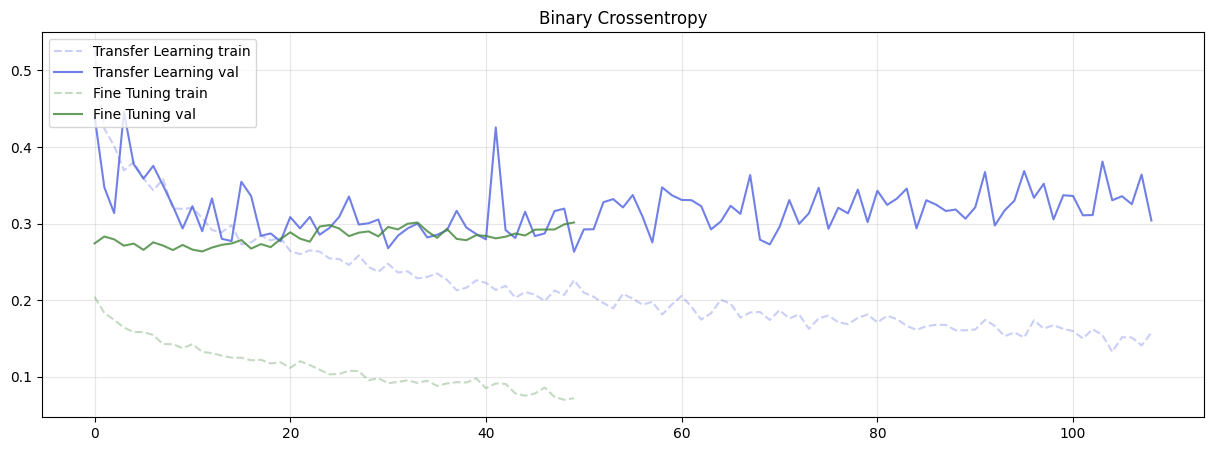

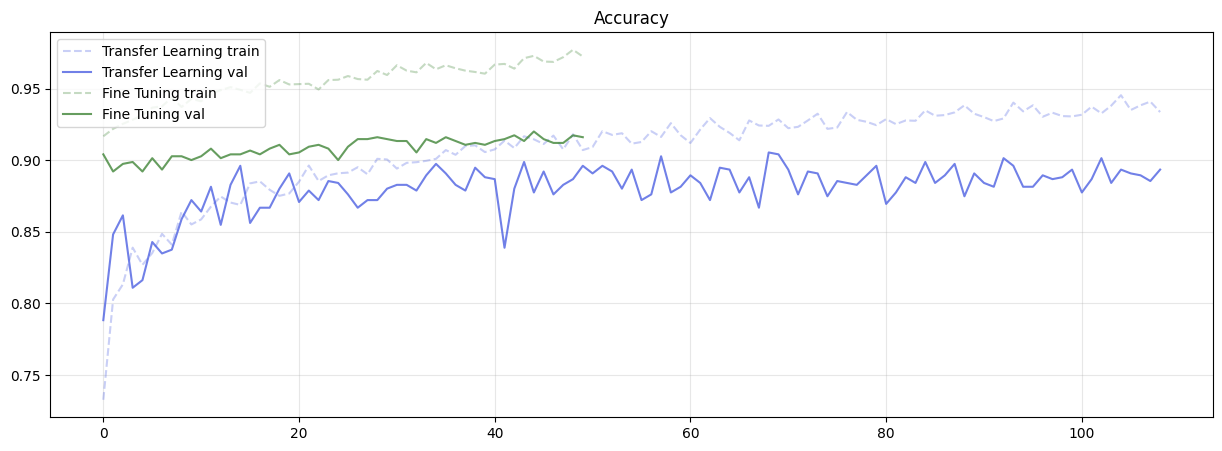

In [24]:
# Plot the re-trained, the transfer learning and the fine-tuned training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], label='Transfer Learning train', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning val', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, label='Fine Tuning train', color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning val', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['binary_accuracy'], label='Transfer Learning train', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_binary_accuracy'], label='Transfer Learning val', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, label='Fine Tuning train', color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning val', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [25]:
ft_model.save('FineTuningModel')

In [26]:
# Re-load the model after first fine tuning phase
# second round of fine tuning where all layers are trainable
ft_model2 = tfk.models.load_model('FineTuningModel')
ft_model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['input_3[0][0]']             
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)            0         ['preprocessing[0][0]']       
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)            0         ['tf.math.truediv[0][0]'] 

In [28]:
# Set all layers as trainable
ft_model2.get_layer('convnext_base').trainable = True
for i, layer in enumerate(ft_model2.get_layer('convnext_base').layers):
   print(i, layer.name, layer.trainable)

ft_model2.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model2.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 convnext_base_prestem_normalization True
2 convnext_base_stem True
3 convnext_base_stage_0_block_0_depthwise_conv True
4 convnext_base_stage_0_block_0_layernorm True
5 convnext_base_stage_0_block_0_pointwise_conv_1 True
6 convnext_base_stage_0_block_0_gelu True
7 convnext_base_stage_0_block_0_pointwise_conv_2 True
8 convnext_base_stage_0_block_0_layer_scale True
9 convnext_base_stage_0_block_0_identity True
10 tf.__operators__.add True
11 convnext_base_stage_0_block_1_depthwise_conv True
12 convnext_base_stage_0_block_1_layernorm True
13 convnext_base_stage_0_block_1_pointwise_conv_1 True
14 convnext_base_stage_0_block_1_gelu True
15 convnext_base_stage_0_block_1_pointwise_conv_2 True
16 convnext_base_stage_0_block_1_layer_scale True
17 convnext_base_stage_0_block_1_identity True
18 tf.__operators__.add_1 True
19 convnext_base_stage_0_block_2_depthwise_conv True
20 convnext_base_stage_0_block_2_layernorm True
21 convnext_base_stage_0_block_2_pointwise_conv_1 True
22 co

In [29]:
# Compile the model
ft_model2.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [30]:
# Fine-tune the model
ft_history2 = ft_model2.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 64,
    epochs = 30,
    validation_data = (X_val*255, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/30
67/67 [==============================] - 168s 1s/step - loss: 0.0863 - accuracy: 0.9650 - val_loss: 0.2997 - val_accuracy: 0.9174
Epoch 2/30
67/67 [==============================] - 62s 920ms/step - loss: 0.0786 - accuracy: 0.9708 - val_loss: 0.2870 - val_accuracy: 0.9161
Epoch 3/30
67/67 [==============================] - 62s 921ms/step - loss: 0.0621 - accuracy: 0.9765 - val_loss: 0.2851 - val_accuracy: 0.9161
Epoch 4/30
67/67 [==============================] - 64s 949ms/step - loss: 0.0633 - accuracy: 0.9765 - val_loss: 0.3219 - val_accuracy: 0.9095
Epoch 5/30
67/67 [==============================] - 62s 919ms/step - loss: 0.0769 - accuracy: 0.9701 - val_loss: 0.3066 - val_accuracy: 0.9055
Epoch 6/30
67/67 [==============================] - 64s 954ms/step - loss: 0.0642 - accuracy: 0.9760 - val_loss: 0.3110 - val_accuracy: 0.9188
Epoch 7/30
67/67 [==============================] - 62s 928ms/step - loss: 0.0622 - accuracy: 0.9753 - val_loss: 0.2783 - val_accuracy: 0.9228
E

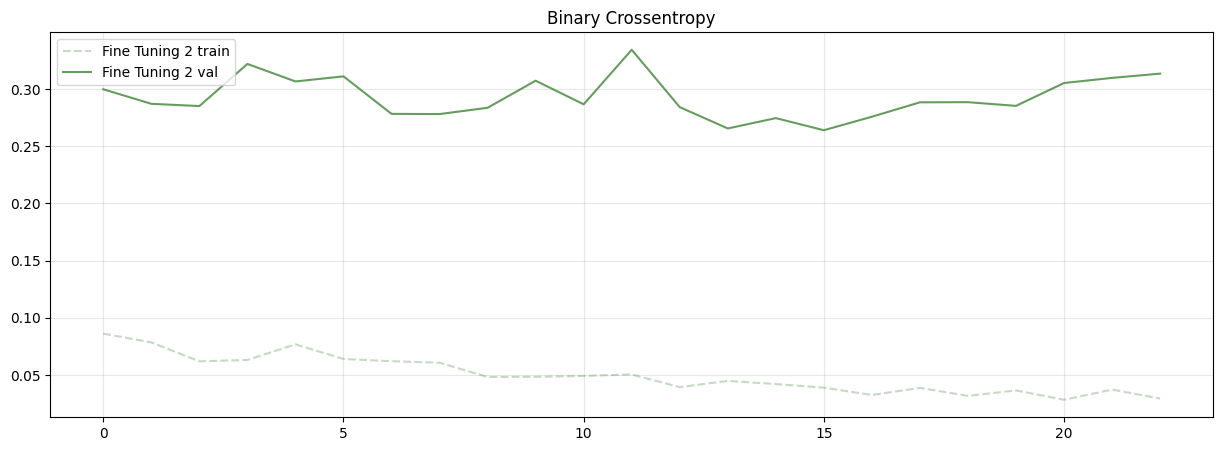

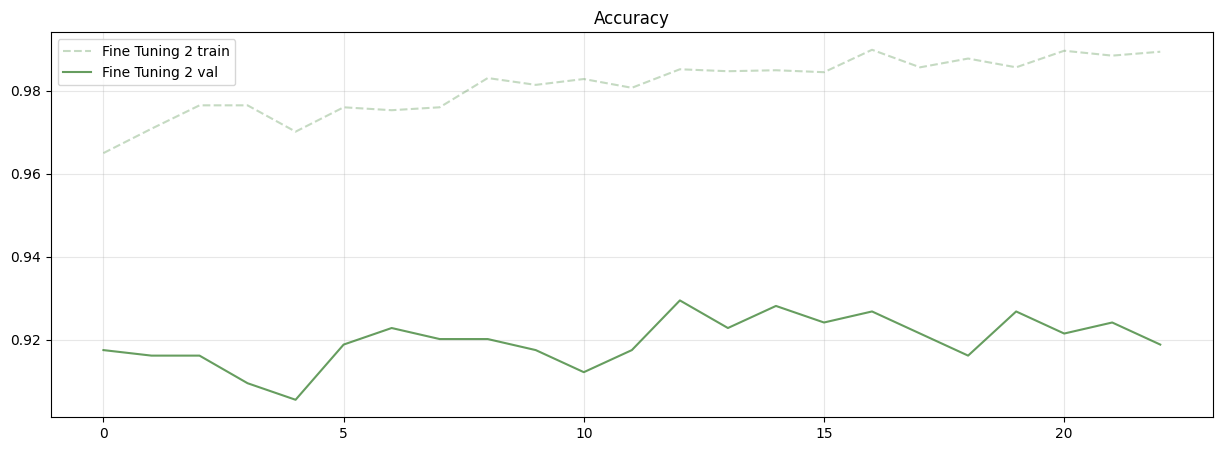

In [31]:
# Plot the training history for the second fine tuning phase
plt.figure(figsize=(15,5))
plt.plot(ft_history2['loss'], alpha=.3, label='Fine Tuning 2 train', color='#408537', linestyle='--')
plt.plot(ft_history2['val_loss'], label='Fine Tuning 2 val', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(ft_history2['accuracy'], alpha=.3, label='Fine Tuning 2 train', color='#408537', linestyle='--')
plt.plot(ft_history2['val_accuracy'], label='Fine Tuning 2 val', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [32]:
ft_model2.save('FineTuningModel_2phases')